## E-V curve
### Step 1: convergence test for ecut and k points


```bash
#!/bin/bash

# Create or truncate calc-ecut.dat to clear previous data
> calc-ecut.dat

# Convergence test of cutoff energy.
# Set a variable ecut from 20 to 80 Ry
for ecut in 20 30 40 50 60 70 80 90; do
    # make input file for scf calculation.
    # ecutwfc is assigned by variable ecut.
cat > ecut.$ecut.in << EOF
&CONTROL
   calculation = 'scf'
   prefix = 'Fe_bcc'
   pseudo_dir = '/home/gu.huang/QE_project/Pseudo/'
   outdir = './output/'
/
&SYSTEM
   a = 2.8665
   ibrav = 3
   nat = 2
   ntyp = 1
   occupations = 'smearing'
   smearing = 'gaussian'
   degauss = 0.02
   ecutwfc = ${ecut}
/
&ELECTRONS
    mixing_beta = 0.7
    conv_thr = 1.0e-9
/
ATOMIC_SPECIES
    Fe  55.845  Fe.pbe-spn-kjpaw_psl.0.2.1.UPF

ATOMIC_POSITIONS crystal
    Fe  0.0  0.0  0.0
    Fe  0.5  0.5  0.5	
K_POINTS automatic
    12 12 12 0 0 0
EOF

    # run scf calculation
    mpirun -np 4 pw.x < ecut.$ecut.in > ecut.$ecut.out
    
    # write cutoff and total energy in calc-ecut.dat.
    awk '/!/{printf"%d %s\n", '$ecut',$5}' ecut.$ecut.out >> calc-ecut.dat
    
# End of the loop
done

```

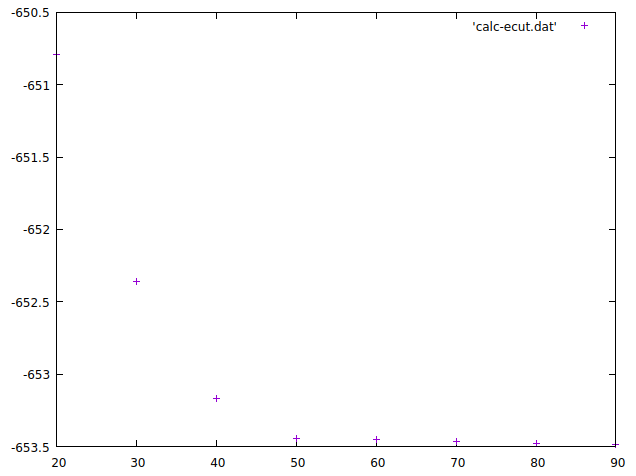

 ```bash
#!/bin/bash

# convergence test of k-points grid.
# set a variable k-point from 4 to 14
> calc-kpoint.dat  # Clear the file for storing k-point convergence data

for k in {4..20}; do
    # make input file for scf calculation.
    # K_POINTS is assigned by variable k.
    cat > kpoint.${k}.in << EOF
&CONTROL
    calculation = 'scf'
    pseudo_dir = '/home/gu.huang/QE_project/Pseudo/'
    outdir = './output/'
    prefix = 'bccFe'
/
&SYSTEM
   a = 2.8665
   ibrav = 3
   nat = 2
   ntyp = 1
   occupations = 'smearing'
   smearing = 'gaussian'
   degauss = 0.02
   ecutwfc = 60
/
&ELECTRONS
    mixing_beta = 0.7
    conv_thr = 1.0e-9
/
ATOMIC_SPECIES
    Fe  55.845  Fe.pbe-spn-kjpaw_psl.0.2.1.UPF

ATOMIC_POSITIONS crystal
    Fe  0.0  0.0  0.0
    Fe  0.5  0.5  0.5
K_POINTS (automatic)
    ${k} ${k} ${k} 0 0 0
EOF

    # run scf calculation
    mpirun -np 4 pw.x < kpoint.${k}.in > kpoint.${k}.out
    
    # write k-point and total energy in calc-kpoint.dat.
    awk '/!/{printf"%d %s\n", '${k}',$5}' kpoint.${k}.out >> calc-kpoint.dat
    
done

```

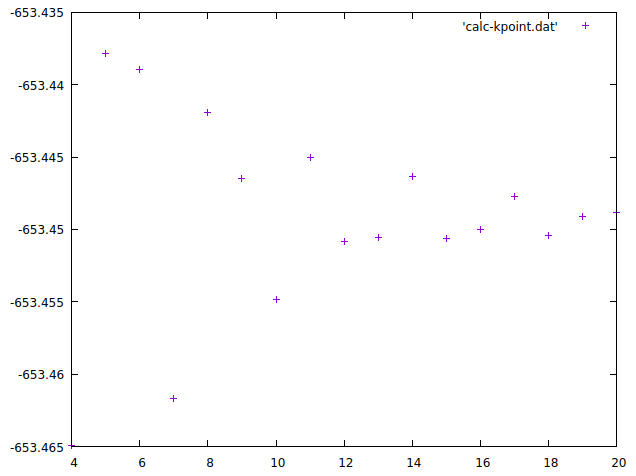

ecut = 60, k = 12 12 12 0 0 0

## Step 2: get energies with different $V$ ($a^3$), fit with ev.x or python code

```bash
#!/bin/bash

> calc-ev.dat

for a in 2.80 2.81 2.82 2.83 2.84 2.85 2.86 2.87 2.88 2.89; do
    cat > ev_a.${a}.in << EOF
    
&CONTROL
    calculation = 'scf'
    pseudo_dir = '/home/gu.huang/QE_project/Pseudo/'
    outdir = './output/'
    prefix = 'bccFe'
/
&SYSTEM
   a = ${a}
   ibrav = 1
   nat = 2
   ntyp = 1
   occupations = 'smearing'
   smearing = 'gaussian'
   degauss = 0.02
   ecutwfc = 60
   ecutrho = 600
   nspin = 2
   starting_magnetization(1) = 0.2 
/
&ELECTRONS
    mixing_beta = 0.4
    conv_thr = 1.0e-9
/
ATOMIC_SPECIES
    Fe  55.845  Fe.pbe-spn-kjpaw_psl.0.2.1.UPF

ATOMIC_POSITIONS crystal
    Fe  0.0  0.0  0.0
    Fe  0.5  0.5  0.5
K_POINTS (automatic)
    12 12 12 0 0 0
EOF

    mpirun -np 4 pw.x < ev_a.${a}.in > ev_a.${a}.out
    
    awk '/!/{printf"%f %s\n", '${a}**3',$5}' ev_a.${a}.out >> calc-ev.dat
    
done
```

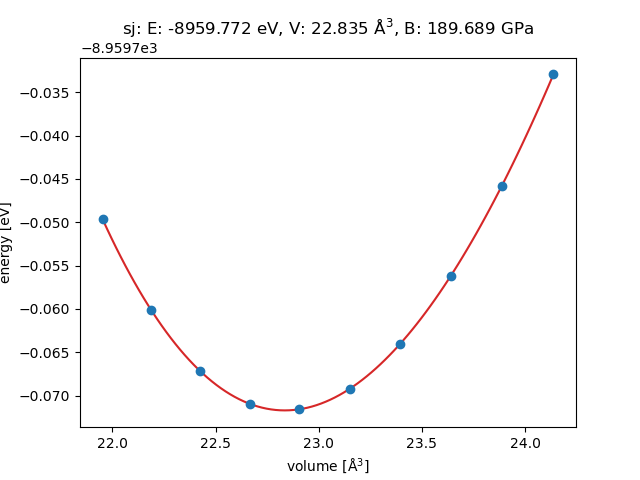

B= 189.7 GPa\
V0=  22.835\
a=  2.837

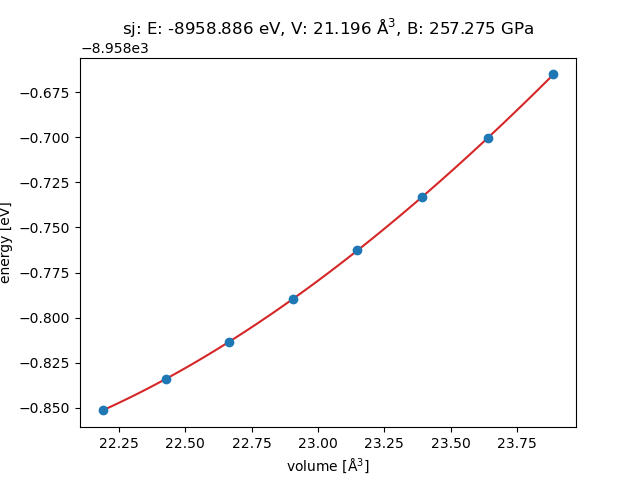

Q1: total energy ~ -653 Ry ~ -8959 eV ?? (~16 in lammps)

## Optimization

```bash
&CONTROL
   calculation = 'vc-relax'
   prefix = 'Fe_bcc'
   pseudo_dir = '/home/gu.huang/QE_project/Pseudo/'
   outdir = './output/'
   etot_conv_thr = 1.0D-5
   forc_conv_thr = 1.0D-4
/

&SYSTEM
   a = 2.86
   ibrav = 1
   nat = 2
   ntyp = 1
   occupations = 'smearing'
   smearing = 'gaussian'
   degauss = 0.02
   ecutwfc = 60
   ecutrho = 600
   nspin = 2
   starting_magnetization(1) = 0.2 
/
&ELECTRONS
   conv_thr = 1.0d-8
   mixing_beta = 0.7
/
&IONS
   ion_dynamics='bfgs'
/
&CELL
   cell_dynamics = 'bfgs'
   cell_dofree = 'all'
   press = 0.0
   press_conv_thr = 0.05
/
ATOMIC_SPECIES
   Fe  55.845  Fe.pbe-spn-kjpaw_psl.0.2.1.UPF

ATOMIC_POSITIONS crystal
   Fe  0.000  0.000  0.000
   Fe  0.500  0.500  0.500	
K_POINTS automatic
   12 12 12  0 0 0
```

In [2]:
import ase.units

```
CELL_PARAMETERS (alat=  5.40461672)
   0.988415099   0.000000000   0.000000000
   0.000000000   0.988415099   0.000000000
   0.000000000   0.000000000   0.988415099
```

In [4]:
5.40461672 * 0.988415099 * ase.units.Bohr

2.8268671831956445